In [1]:
!pip install pmdarima

from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:00


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Load the Walmart Dataset
file_path = '/content/drive/My Drive/walmart.csv'  # Update with the correct Walmart dataset path
walmart_df = pd.read_csv(file_path)

Mounted at /content/drive


In [3]:
# Display the first few rows
walmart_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Oct 3, 2024",80.30,80.58,79.85,80.43,80.43,"11,591,400"
1,"Oct 2, 2024",80.99,80.99,80.12,80.43,80.43,"16,618,300"
2,"Oct 1, 2024",80.68,81.53,80.44,81.27,81.27,"16,054,200"
3,"Sep 30, 2024",79.89,80.94,79.86,80.75,80.75,"18,997,000"
4,"Sep 27, 2024",79.90,80.29,79.60,79.78,79.78,"11,899,100"


In [4]:
# Data Preprocessing
# Convert Date column to datetime format
walmart_df['Date'] = pd.to_datetime(walmart_df['Date'])


In [5]:
walmart_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-10-03,80.30,80.58,79.85,80.43,80.43,"11,591,400"
1,2024-10-02,80.99,80.99,80.12,80.43,80.43,"16,618,300"
2,2024-10-01,80.68,81.53,80.44,81.27,81.27,"16,054,200"
3,2024-09-30,79.89,80.94,79.86,80.75,80.75,"18,997,000"
4,2024-09-27,79.90,80.29,79.60,79.78,79.78,"11,899,100"


In [6]:
# Set the Date as the index
walmart_df.set_index('Date', inplace=True)



In [7]:
walmart_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-10-03,80.30,80.58,79.85,80.43,80.43,"11,591,400"
2024-10-02,80.99,80.99,80.12,80.43,80.43,"16,618,300"
2024-10-01,80.68,81.53,80.44,81.27,81.27,"16,054,200"
2024-09-30,79.89,80.94,79.86,80.75,80.75,"18,997,000"
2024-09-27,79.90,80.29,79.60,79.78,79.78,"11,899,100"


In [8]:
# Handle missing values if any
walmart_df.fillna(method='ffill', inplace=True)



<ipython-input-8-158edd3d6866>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  walmart_df.fillna(method='ffill', inplace=True)


In [9]:
# Display summary statistics
walmart_df.describe()

,Open,High,Low,Close,Adj Close
count,6228.000000,6228.000000,6228.000000,6228.000000,6228.000000
mean,26.616575,26.846708,26.394171,26.623149,22.382845
std,12.871590,12.954643,12.792266,12.878702,14.355149
min,14.000000,14.230000,13.810000,14.090000,9.340000
25%,17.530000,17.710000,17.360000,17.530000,11.840000
50%,20.550000,20.750000,20.360000,20.575000,15.885000
75%,31.735000,31.965000,31.510000,31.702500,28.720000
max,81.040000,81.600000,80.680000,81.400000,81.400000


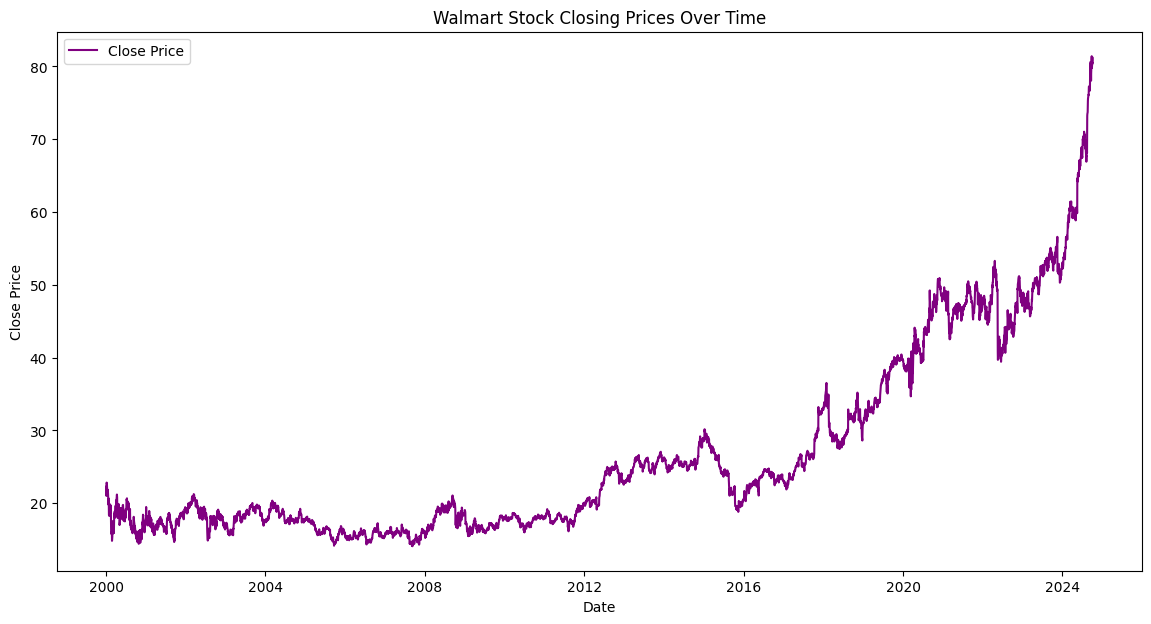

In [11]:
# Data Visualization
# Plot closing price over time
plt.figure(figsize=(14, 7))
plt.plot(walmart_df['Close'], label='Close Price', color='purple')
plt.title('Walmart Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

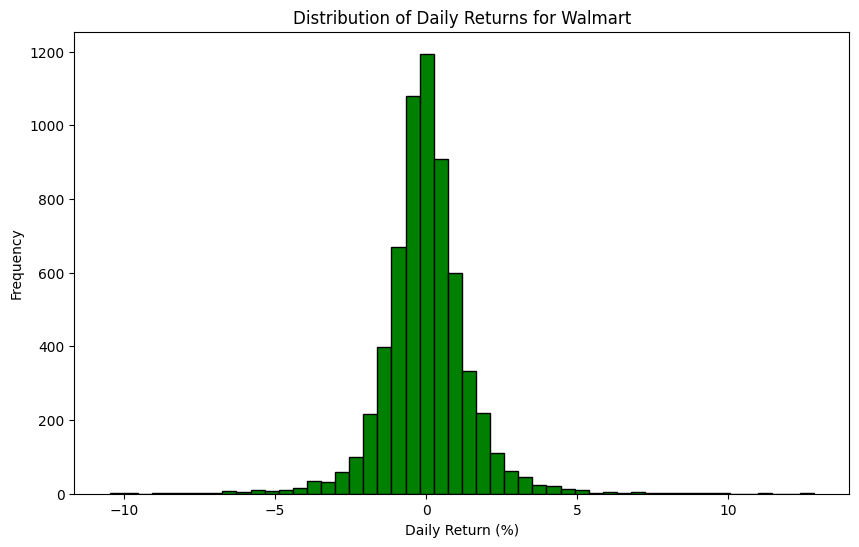

In [15]:
# Calculate daily returns
walmart_df['Daily_Return'] = walmart_df['Close'].pct_change() * 100

# Plot histogram of daily returns
plt.figure(figsize=(10, 6))
plt.hist(walmart_df['Daily_Return'].dropna(), bins=50, color='green', edgecolor='black')
plt.title('Distribution of Daily Returns for Walmart')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.show()

# SARIMA

In [17]:
# Convert daily data to monthly if needed
data = walmart_df['Close'].resample('M').mean()  # Using monthly data as an example


# Split the data into training and test sets
train_data = data[data.index < '2024-01-01']
test_data = data[data.index >= '2024-01-01']  # Start forecasting after the last training point


<ipython-input-17-ad95fcfba4d4>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = walmart_df['Close'].resample('M').mean()  # Using monthly data as an example


In [18]:
# Use auto_arima to find the best p, d, q, P, D, Q values with seasonality
auto_model = auto_arima(train_data, seasonal=True, m=12, trace=True, stepwise=True)
print(auto_model.summary())

# Get the optimal order and seasonal order
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
sarima_model = SARIMAX(train_data, order=best_order, seasonal_order=best_seasonal_order)
sarima_model_fit = sarima_model.fit()

# Forecast for an extended period (e.g., up to the end of 2028)
extended_forecast_steps = 60  # 60 months (5 years) from 2024, adjust as needed
sarima_forecast = sarima_model_fit.forecast(steps=extended_forecast_steps)

# Generate dates for the forecasted values
forecast_start = pd.to_datetime(test_data.index[0])  # Ensure forecast_start is a datetime object
forecast_index = pd.date_range(start=forecast_start, periods=extended_forecast_steps, freq='M')

# Calculate confidence intervals for the forecast
conf_int = sarima_model_fit.get_forecast(steps=extended_forecast_steps).conf_int()



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=885.005, Time=3.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=909.210, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=906.284, Time=0.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=904.653, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=909.555, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=890.169, Time=2.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=889.706, Time=0.92 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=886.892, Time=5.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=887.095, Time=5.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=891.816, Time=1.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=891.287, Time=2.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=890.154, Time=2.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=888.964, Time=5.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=886.015, Time=3.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=886.121, Time=5.55 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,1)[12] intercept   : AIC=886.632, Time=3.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,0,1)[12] intercept   : AIC=885.702, Time=2.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=884.419, Time=3.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=889.628, Time=0.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=889.171, Time=0.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=886.201, Time=2.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=886.167, Time=3.01 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=891.279, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=890.652, Time=1.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=889.542, Time=1.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=888.412, Time=3.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=895.584, Time=1.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=899.292, Time=1.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=903.273, Time=0.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=886.058, Time=0.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=891.371, Time=0.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12]             : AIC=882.906, Time=0.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12]             : AIC=889.133, Time=0.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12]             : AIC=888.591, Time=0.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,1)[12]             : AIC=884.663, Time=1.89 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,2)[12]             : AIC=884.625, Time=2.03 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=891.179, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,2)[12]             : AIC=890.023, Time=0.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12]             : AIC=888.700, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,2)[12]             : AIC=inf, Time=6.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12]             : AIC=893.874, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12]             : AIC=897.662, Time=0.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12]             : AIC=884.662, Time=0.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12]             : AIC=884.579, Time=0.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12]             : AIC=901.946, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12]             : AIC=884.698, Time=0.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[12]             : AIC=889.946, Time=0.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,1)[12]             : AIC=884.083, Time=1.09 sec

Best model:  ARIMA(1,1,1)(1,0,1)[12]          
Total fit time: 86.961 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  288
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -436.453
Date:                            Mon, 17 Mar 2025   AIC                            882.906
Time:                                    15:09:47   BIC                            901.204
Sample:                                01-31-2000   HQIC                           890.240
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

<ipython-input-18-2e888f5101c3>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=forecast_start, periods=extended_forecast_steps, freq='M')


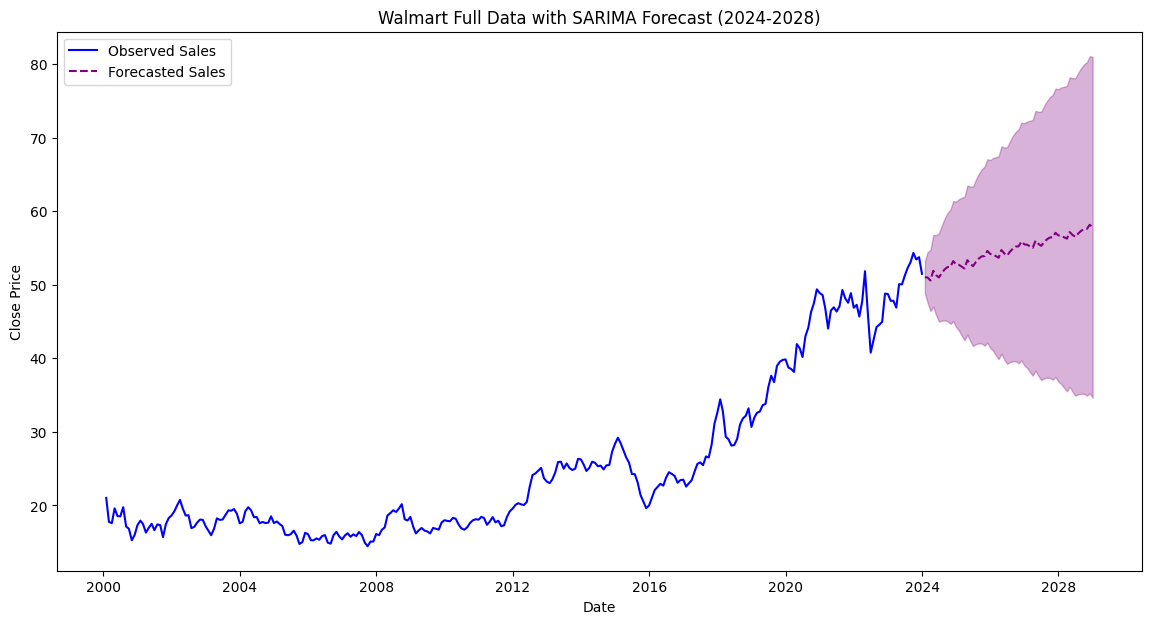

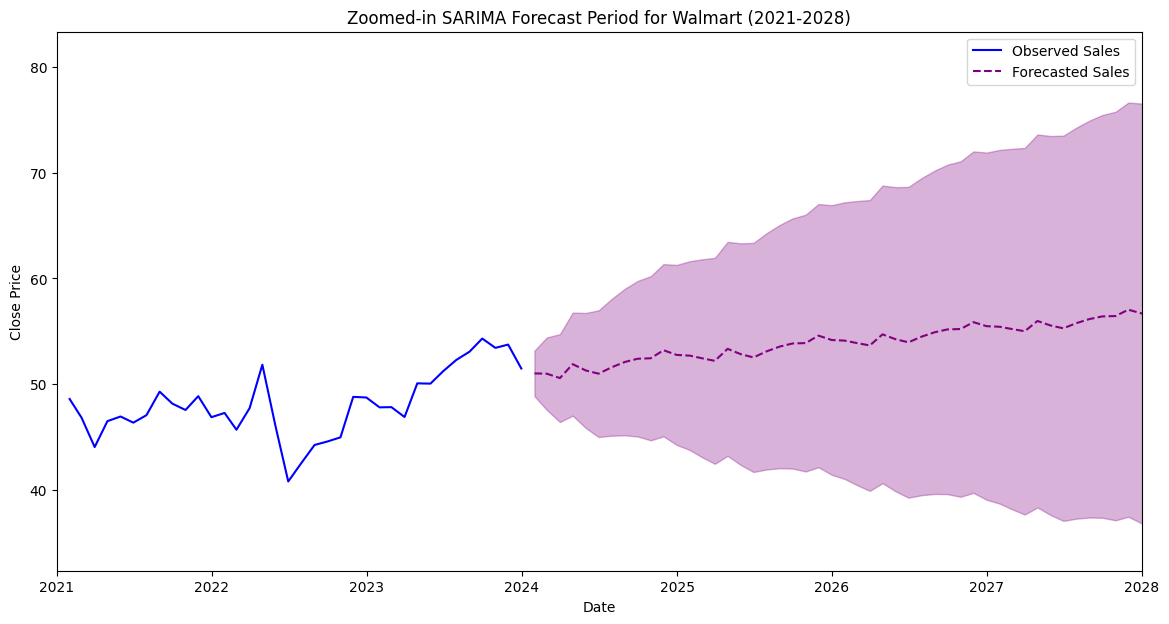

In [23]:
# Plot 1: Full data with extended forecast
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Observed Sales', color='blue')
plt.plot(forecast_index, sarima_forecast, color='purple', linestyle='--', label='Forecasted Sales')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='purple', alpha=0.3)
plt.title('Walmart Full Data with SARIMA Forecast (2024-2028)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot 2: Zoomed-in view of the forecast period only
plt.figure(figsize=(14, 7))
plt.plot(train_data.index[-36:], train_data[-36:], label='Observed Sales', color='blue')  # Show recent data only
plt.plot(forecast_index, sarima_forecast, color='purple', linestyle='--', label='Forecasted Sales')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='purple', alpha=0.3)
plt.xlim([pd.to_datetime('2021-01-01'), pd.to_datetime('2028-01-01')])  # Ensure the date limits are datetime objects
plt.title('Zoomed-in SARIMA Forecast Period for Walmart (2021-2028)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define the evaluation period (2021-2024)
evaluation_start = '2021-01-01'
evaluation_end = '2024-01-01'

# Subset the evaluation period from train_data
evaluation_actual = train_data[(train_data.index >= evaluation_start) & (train_data.index < evaluation_end)]

# Train the SARIMA model on data before the evaluation period
train_for_evaluation = train_data[train_data.index < evaluation_start]
sarima_model_eval = SARIMAX(train_for_evaluation, order=best_order, seasonal_order=best_seasonal_order)
sarima_model_eval_fit = sarima_model_eval.fit()

# Generate forecast for the evaluation period
evaluation_forecast_steps = len(evaluation_actual)  # Number of months in the evaluation period
forecast_start = pd.to_datetime(evaluation_actual.index[0])  # Start of the forecast
evaluation_forecast_index = pd.date_range(start=forecast_start, periods=evaluation_forecast_steps, freq='M')

# Get the forecasted values
evaluation_forecast = sarima_model_eval_fit.get_forecast(steps=evaluation_forecast_steps)
forecast_values = evaluation_forecast.predicted_mean

# Align forecast values to actual data
forecast_values.index = evaluation_forecast_index

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(evaluation_actual, forecast_values)
mse = mean_squared_error(evaluation_actual, forecast_values)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 2.53
Mean Squared Error (MSE): 9.93
Root Mean Squared Error (RMSE): 3.15


<ipython-input-27-eb07143c5398>:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  evaluation_forecast_index = pd.date_range(start=forecast_start, periods=evaluation_forecast_steps, freq='M')


# Holt Winters Forecast

<ipython-input-25-bc1688d0c991>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  walmart_monthly = walmart_df['Close'].resample('M').mean()  # Monthly data
<ipython-input-25-bc1688d0c991>:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=forecast_start, periods=extended_forecast_steps, freq='M')


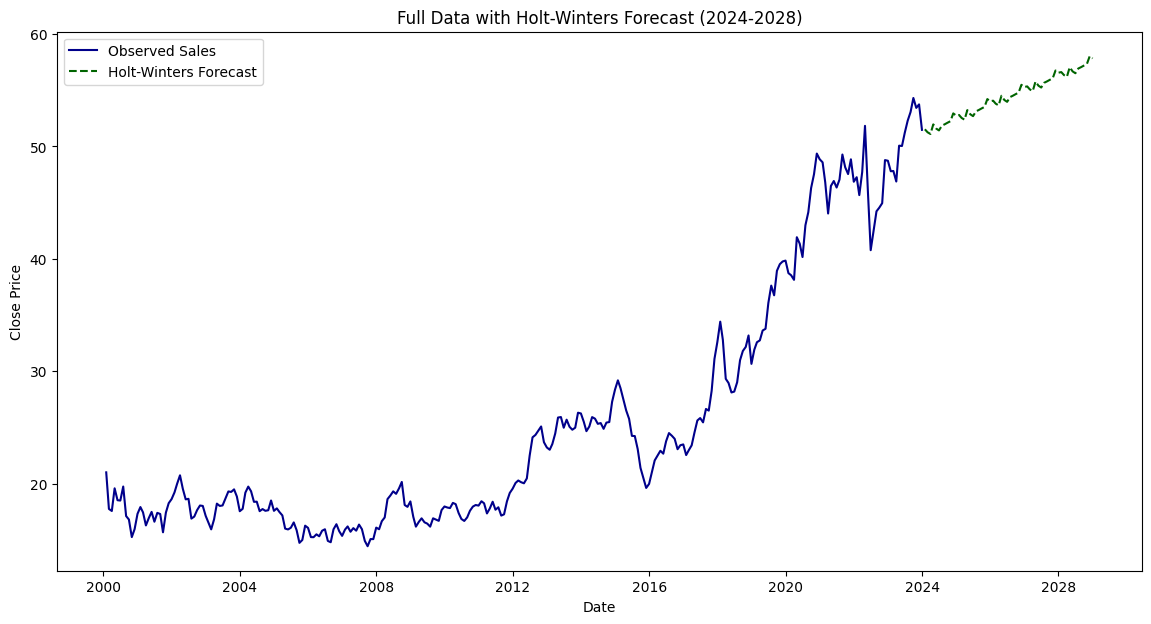

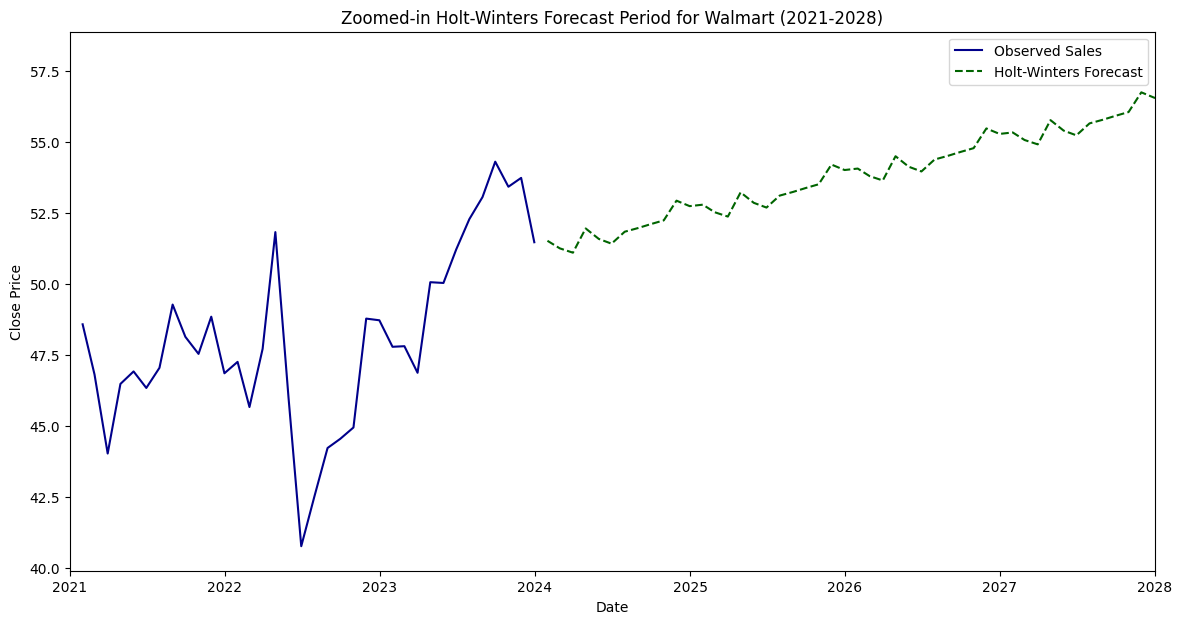

In [ ]:
!pip install statsmodels
# Import necessary libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# Convert daily data to monthly using the updated alias 'ME' for month-end
walmart_monthly = walmart_df['Close'].resample('M').mean()  # Monthly data

# Choose the data to proceed with
data = walmart_monthly

# Split the data into training and test sets
train_data = data[data.index < '2024-01-01']
test_data = data[data.index >= '2024-01-01']  # Start forecasting after the last training point

# Initialize and fit the Holt-Winters model
holt_winters_model = ExponentialSmoothing(train_data, seasonal='add', trend='add', seasonal_periods=12)
holt_winters_fit = holt_winters_model.fit()

# Forecast for an extended period (e.g., up to the end of 2028)
extended_forecast_steps = 60  # 60 months (5 years) from 2024
holt_winters_forecast = holt_winters_fit.forecast(steps=extended_forecast_steps)

# Generate dates for the forecasted values using 'M' alias
forecast_start = pd.to_datetime(test_data.index[0])
forecast_index = pd.date_range(start=forecast_start, periods=extended_forecast_steps, freq='M')

# Note: Holt-Winters does not directly provide prediction intervals; use a workaround or approximation if needed.
# Here we plot the forecast without confidence intervals, or use a custom approach to estimate them if critical.

# Plot 1: Full data with extended Holt-Winters forecast
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Observed Sales', color='darkblue')
plt.plot(forecast_index, holt_winters_forecast, color='darkgreen', linestyle='--', label='Holt-Winters Forecast')
plt.title('Full Data with Holt-Winters Forecast (2024-2028)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot 2: Zoomed-in view of the forecast period only
plt.figure(figsize=(14, 7))
plt.plot(train_data.index[-36:], train_data[-36:], label='Observed Sales', color='darkblue')  # Show recent data only
plt.plot(forecast_index, holt_winters_forecast, color='darkgreen', linestyle='--', label='Holt-Winters Forecast')
plt.xlim([pd.to_datetime('2021-01-01'), pd.to_datetime('2028-01-01')])  # Set date limits
plt.title('Zoomed-in Holt-Winters Forecast Period for Walmart (2021-2028)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()





In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define the evaluation period (2021-2024)
evaluation_start = '2021-01-01'
evaluation_end = '2024-01-01'

# Subset the evaluation period from train_data
evaluation_actual = train_data[(train_data.index >= evaluation_start) & (train_data.index < evaluation_end)]

# Train the Holt-Winters model on data before the evaluation period
train_for_evaluation = train_data[train_data.index < evaluation_start]
holt_winters_model_eval = ExponentialSmoothing(train_for_evaluation, seasonal='add', trend='add', seasonal_periods=12)
holt_winters_fit_eval = holt_winters_model_eval.fit()

# Generate forecast for the evaluation period
evaluation_forecast_steps = len(evaluation_actual)  # Number of months in the evaluation period
forecast_start = pd.to_datetime(evaluation_actual.index[0])  # Start of the forecast
evaluation_forecast_index = pd.date_range(start=forecast_start, periods=evaluation_forecast_steps, freq='M')

# Get the forecasted values
evaluation_forecast = holt_winters_fit_eval.forecast(steps=evaluation_forecast_steps)

# Align forecast values to actual data
forecast_values = pd.Series(evaluation_forecast.values, index=evaluation_forecast_index)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(evaluation_actual, forecast_values)
mse = mean_squared_error(evaluation_actual, forecast_values)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 8.07
Mean Squared Error (MSE): 78.10
Root Mean Squared Error (RMSE): 8.84


<ipython-input-26-161996d40b32>:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  evaluation_forecast_index = pd.date_range(start=forecast_start, periods=evaluation_forecast_steps, freq='M')
